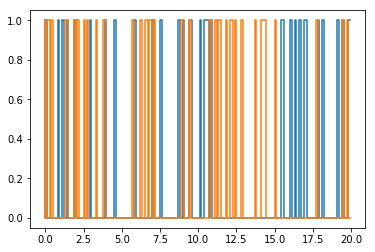

Number of events A:  1025
Number of events B:  1023
Lambda A:  1.70833333333
Lambda B:  1.705


In [1]:
import numpy as np
from scipy.stats import poisson
import random
import matplotlib.pyplot as plt

fps  =10

T = 600 # in seconds
tau = 0.05
win_t = np.arange(0, 2, 1/fps)

#random dataset
onepr = 1./6
a = np.random.choice([0,1], size=6000, p=[1-onepr, onepr])
b = np.random.choice([0,1], size=6000, p=[1-onepr, onepr])

#shifted dataset
shft = 5
c = np.hstack((a.copy()[shft:], np.zeros(shft)))
ind = np.random.choice(np.arange(0, fps*T, 1), size =1000, replace = False)
c[ind] = 0

#time vector
time = np.arange(0,T,1/fps)

plt.step(time[:200], a[:200])
plt.step(time[:200], b[:200])
plt.show()

#total number of events
na = sum(a) # number of spikes in a
nb = sum(b) #number of spikes in b 

print("Number of events A: ", na)
print("Number of events B: ", nb)

#rate of events
lambdaa = na/T
lambdab = nb/T
print("Lambda A: ", lambdaa)
print("Lambda B: ", lambdab)

In [2]:
def eventCoin(a, b, #two binary signals to compare
              win_t, #vector of time (s) for window
              ratetype = 'precursor', #precursor or trigger
              tau = 0, #lag coefficeint 
              fps = 10, #sampling rate, frames per sec
              verbose = True,
              veryVerbose = False):
    
    na = sum(a)
    nb = sum(b)
    
    #find all indices for each event
    a_ind = [i for i, e in enumerate(a) if e != 0]
    b_ind = [i for i, e in enumerate(b) if e != 0]
    
    #convert window times to window frames
    win_fr = win_t * fps 
    
    #create index difference matrix
    ind_diff = np.zeros((len(a_ind), len(b_ind)))

    for i,inda in enumerate(a_ind): # rows
        for j,indb in enumerate(b_ind): # columns
            ind_diff [i,j]= inda - (tau*fps) - indb

    #replace all neg values with 0
    ind_diff[ind_diff< 0] = 0
    
    if veryVerbose:
        print('Size of difference array: ',ind_diff.shape)
        plt.imshow(ind_diff)
        plt.title('Difference in indices')
        plt.xlabel('indices from list a')
        plt.ylabel('indices from list b')
        plt.colorbar()
        plt.show()

    #create event matrix
    events = np.zeros((ind_diff.shape[0], len(win_fr)))
    
    for i, win in enumerate(win_fr):
        if verbose:
            print('Calculating coincidence rate for window ' + str(win/fps) +'sec(s)')
        for j in range(ind_diff.shape[0]):
            for k in range(ind_diff.shape[1]):
                if ind_diff[j,k] > 0 and ind_diff[j,k] < win:
                    events[j, i] = 1
                    
    if ratetype == 'precursor':
        rate_win = np.sum(events, axis=0)/na
        
    if ratetype == 'trigger':
        rate_win = np.sum(events, axis=0)/nb
    
    if verbose:
        plt.imshow(events, aspect = 'auto')
        plt.title('Event matrix')
        plt.xlabel('Time window')
        plt.ylabel('Coincidence per event')
        plt.show()

        plt.plot(win_t, rate_win)
        plt.title('Rates per time window')
        plt.xlabel('Time window (sec)')
        if ratetype == 'precursor':
            plt.ylabel('Precursor coincidence rate')
        if ratetype == 'trigger':
            plt.ylabel('Trigger coincidence rate')
        plt.show()

    return rate_win, na, nb

In [3]:
def getResults(rate_win,              
              win_t, #vector of time (s) for window
              na, #number of events in a
              nb, #number of event in b
              ratetype = 'precursor', #precursor or trigger
              T = 600, #length (s) of vector
              tau = 0, #lag coefficeint 
              fps = 10, #sampling rate, frames per sec
              verbose = True,
              veryVerbose = False):
    
    #expected rate and stdev of the rate
    rho = 1 - win_t/(T - tau)
    exp_rate = na*(1 - (rho)**nb)
    exp_std = np.sqrt(1/na*(1-rho**nb) * rho**nb)
    
    #quantiles used for graphing
    if verbose:
        perc = np.array([1, 2.5, 25, 50, 75, 97.5, 99])
        mark = ['k:', 'k-.', 'k--', 'k-', 'k--','k-.', 'k:']
    #number samples for null hypothesis
    k=10000

    sample = np.zeros((exp_rate.shape[0], k))
    quantile = np.zeros((exp_rate.shape[0], perc.shape[0]))
    results = np.zeros(exp_rate.shape[0])

    for i, r in enumerate(exp_rate):
        sample[i,:] = poisson.rvs(r, size=k)
        quantile[i,:] = np.percentile(sample[i,:], perc)/na
        results[i] = sum(rate_win[i] < sample[i, :]/na)/k
        if veryVerbose:
            print(str(win_t[i]) + 'sec(s) time window produces a p value: ' + str(results[i]))

    if verbose:
        for j, r in enumerate(results):
            if r < 0.05:
                print(str(win_t[j]) + 'sec(s) time window produces a significant value: p=' + str(r))
    
    # plot sample values
    if veryVerbose:
        plt.imshow(sample, aspect = 'auto')
        plt.colorbar()
        plt.show()

    if verbose:
        for i in range(len(perc)):
            plt.plot(win_t, quantile[:, i], mark[i], label=perc[i])

        plt.plot(win_t, rate_win)
        plt.title('Rates per time window')
        plt.xlabel('Time window (sec)')
        plt.ylabel('Precursor coincidence rate')
        plt.legend()
        plt.show()
    
    return (results)

0.0sec(s) time window produces a significant value: p=0.0


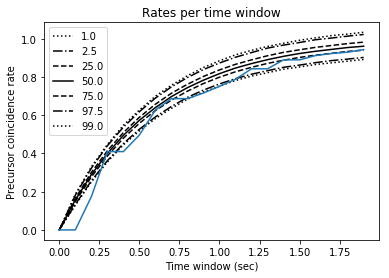

0.0sec(s) time window produces a significant value: p=0.0
0.3sec(s) time window produces a significant value: p=0.0077
0.6sec(s) time window produces a significant value: p=0.0
0.7sec(s) time window produces a significant value: p=0.0
0.8sec(s) time window produces a significant value: p=0.0
0.9sec(s) time window produces a significant value: p=0.0
1.0sec(s) time window produces a significant value: p=0.0
1.1sec(s) time window produces a significant value: p=0.0
1.2sec(s) time window produces a significant value: p=0.0
1.3sec(s) time window produces a significant value: p=0.0
1.4sec(s) time window produces a significant value: p=0.0
1.5sec(s) time window produces a significant value: p=0.0003
1.6sec(s) time window produces a significant value: p=0.0025
1.7sec(s) time window produces a significant value: p=0.0093
1.8sec(s) time window produces a significant value: p=0.0185
1.9sec(s) time window produces a significant value: p=0.0353


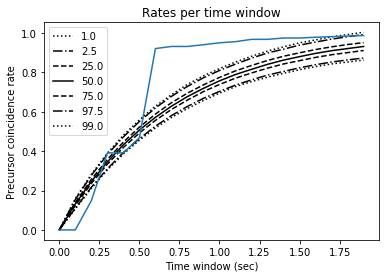

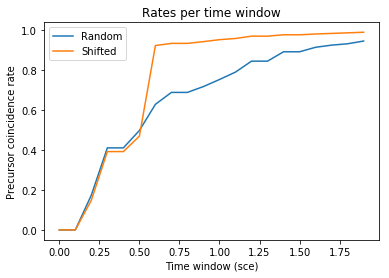

In [5]:
rand, na, nb = eventCoin(a,b, win_t=win_t, ratetype='precursor', verbose = False, veryVerbose = False)
shifted, na, nc = eventCoin(a,c, win_t=win_t, ratetype = 'precursor', verbose = False, veryVerbose=False)

plt.plot(win_t, rand,  label='Random')
plt.plot(win_t, shifted, label='Shifted')
plt.title('Rates per time window')
plt.xlabel('Time window (sce)')
plt.ylabel('Precursor coincidence rate')
plt.legend()
plt.show()

rand_results = getResults(rand, win_t=win_t, na=na, nb=nb, verbose = True, veryVerbose = False)
shifted_results = getResults(shifted, win_t=win_t, na=na, nb=nc, verbose = True, veryVerbose = False)